## 9. Minimum-maximum módszer, MinMaxMethod

A minimum-maximum módszeres kiértékelésre két különböző út van, az interaktív matplotlib ablak, illetve a manuális minimum maximum megadás. Itt a már meglévő interferogramot értékelem ki, illetve szimulált interferogramokon is bemutatok funkciókat.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysprint as ps

c:\pyt\pysprint\pysprint\core\bases\dataset.py:203: PySprintWarning: Extreme values encountered during normalization.
Nan values: 105
Inf values: 1
  PySprintWarning


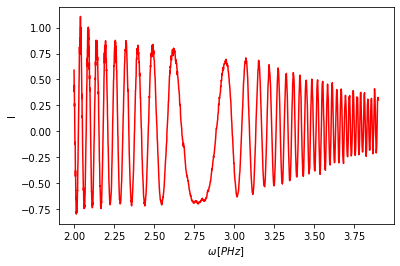

In [2]:
m = ps.MinMaxMethod.parse_raw(
    'datasets/ifg.trt',
    'datasets/ref.trt',
    'datasets/sam.trt',
    skiprows=8,
    meta_len=6,
    delimiter=";",
    decimal=","
)
m.chdomain()
m.slice(2, 3.9)

m.plot()

### 9.1 A manuális módszer
Pontosan megtalálni a szélsőértékek helyét *csak kódot használva* különböző adatsorok esetén elég nehéz feladat. Manuális beállítás esetén `MinMaxMethod.xmin` és `MinMaxMethod.xmax` paramétereket kell megadni, melyek a minimumok és maximumok helyeire mutató `np.ndarray`-ok. A szélsőértékek megtalálásához a `MinMaxMethod.detect_peak` és a `MinMaxMethpd.detect_peak_cwt` két beépített segédfüggvény. Ez a két függvény a `scipy.signal.find_peaks` és a `scipy.signal.find_peaks_cwt` függvényeket használja a kódon belül.

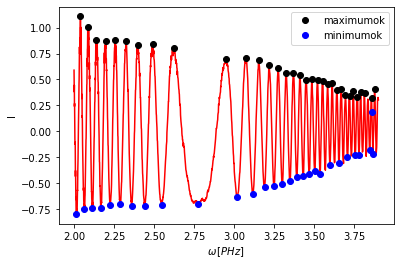

In [3]:
xmax, ymax, xmin, ymin = m.detect_peak(pmax=0.5, pmin=4, threshold=0.15)

plt.figure()
m.plot()
plt.plot(xmax, ymax, "ko", label="maximumok")
plt.plot(xmin, ymin, "bo", label="minimumok")
plt.legend()

Látható, hogy bármennyit is állítgatjuk a paraméterek értékeit, tökéletes eredményt a legtöbb esetben nem tudunk elérni. A `detect_peak` és a `detect_peak_cwt` rögzíti automatikusan a minimumok és a maximumok helyét. Ezután két lehetőségünk van. Az első, hogy meghívjuk a `build_phase(reference_point, SPP_callbacks=None)` függvényt, amivel a program az eddig megadott szélsőértékek, a referencia pont és az SPP-k helyzetéből meghatározza a fázist (`ps.core.phase.Phase`), majd az kerül visszatérítésre. Fontos megadni az `SPP_callbacks` argumentumot. Ez lehet szám, vagy list számokkal. A programnak fontos tudnia ezekről, hiszen ezek adják meg azokat a pozíciókat, ahol a fázis menete előjelet vált. Ha nem adtuk meg az `SPP_callbacks` argumentumot, akkor a program megnézi, hogy az interferogram objektumon állítottunk-e be állandó fázisú pontot, és amennyiben igen azt fogja használni. 

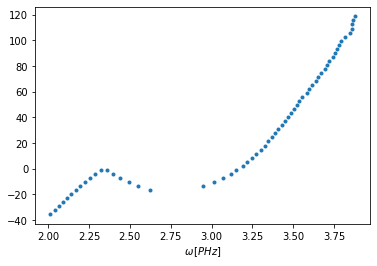

In [4]:
fazis = m.build_phase(reference_point=2.355, SPP_callbacks=2.77);
fazis.plot()

Látható, hogy ebben az esetben a referencia pont környékén letörés tapasztalható. Ez azért van, mert a program a referencia pontból kiindulva két irányba kezdi felépíteni a fázist, így ott legtöbbször a görbe nem folytonos. Itt két lehetőségünk van: használjuk a `flip_around(value, side="left")` függvényt, és átfordítjuk a fázisgrafikon megfelelő részét, vagy egyszerűen a `slice(start, stop)` függvényt meghívva csak az egyik oldalt használjuk. Itt egyszerűen csak a referencia ponttól nagyobb körfrekvencia értékeket fogom használni.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

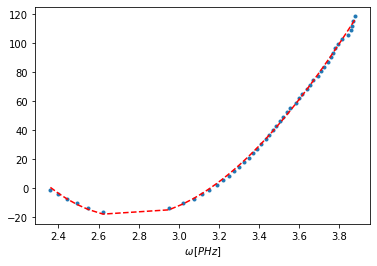

In [5]:
fazis.slice(2.355, None)
fazis.fit(reference_point=2.355, order=3);
fazis.plot()

Köszönhetően a szélsőértékek pontatlan meghatározásának az eredmény is eléggé pontatlan
(körülbelül GD = $-83 fs$, GDD = $165 fs^2$, TOD = $115 fs^3$ lenne a valós), ráadásul az előjelek sem stimmelnek.

### 9.2 Az interaktív módszer

Vizsgáljuk meg, hogy pontos szélsőértékek esetén hogyan fest a fenti számolás. Ehhez használom az `init_edit_session` függvényt, ahol bejelölöm a szélsőértékeket. Pontot hozzáadni az `i`, törölni a `d` billentyűvel lehet. Ezután a `calculate` metódust fogom használni, amely felépíti a fázist és görbét is illeszt.


**FONTOS:**
Az állandó fázisú pontokat is be kell jelölni, mint szélsőérték, mivel a program megkeresi a megadott SPP helyzetekhez a legközelebbi szélsőértéket és azt kezeli állandó fázisú pontként.

In [6]:
# interaktív módba váltás
with ps.interactive():
    # az interaktív szélsőérték kereső elindítása
    m.init_edit_session(threshold=0.3)

70 extremal points were recorded.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

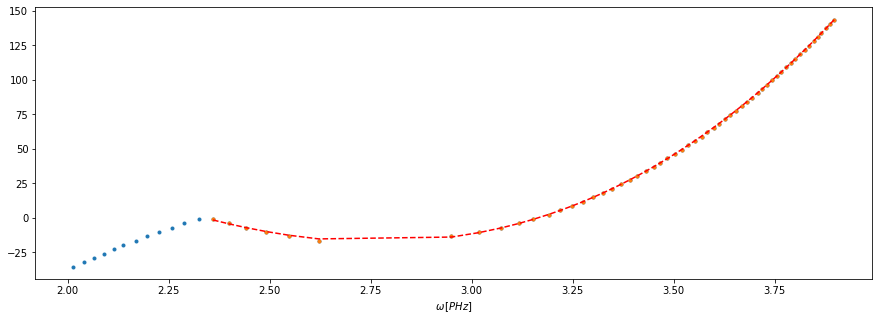

In [7]:
# Itt nem adok meg SPP_callbacks értéket, hanem magára az objektumra állítom be
# az állandó fázisú pont helyét. Ekkor ezt fogja a használni a program.
# Ha mindkettő adott, akkor az SPP_callbacks argumentum értéke preferált.
m.positions = 2.77

m.calculate(reference_point=2.355, order=3, scan=True, show_graph=True);

Fent a `calculate` metódusban az `scan` argumentumról: Az alapértelmezett értéke `False`, vagyis a metódus csak felépíti a fázist, majd nem végez semmilyen vizsgálatot rajta, hanem csak a megadott görbét illeszti rá, majd abból számolja a diszperziós együtthatókat. Ez akkor lehet jó, amikor a referencia pont és az SPP egybeesik, vagy a referencia pont az adatsor szélén van, mivel ezekben az esetekben a görbében nincs törés. Ha `True`, akkor felbontja a referencia pont mentén a fázisgrafikont, majd külön kiszámolja mindkét oldalra a diszperziós együtthatókat. Ha azok kevéssé térnek el, akkor az együtthatók átlagát adja vissza, természetesen az előjelek egyeztetésével. Ha az együtthatók egy előre meghatározott határnál jobban eltérnek a két oldalon, akkor csak az egyik oldalon számolt együtthatókat adja vissza. Ekkor mindig azt az oldalt használja, ahol több adatpontunk van. Látható, hogy a fenti példában a csak a jobb oldalt használta. A teljes output itt is el van rejtve a felhasználó elől, de elérhető: lefuttatom újra, úgy, hogy látható legyen:

[ _evaluate.py:143 -       min_max_method() ] refpoint set to 2.355094355366024 instead of 2.355094355366024.
[ _evaluate.py:159 -       min_max_method() ] SPP_callbacks are now 0.41490564463397606, with ref_point 2.355094355366024.
[ _evaluate.py:67 -        _split_on_SPP() ] 0.41490564463397606 is outside of array range, skipping.
[ _evaluate.py:105 - _build_single_phase_data() ] x was split to 1 pieces (including the flip).
[ _evaluate.py:64 -        _split_on_SPP() ] split value was set to 0.42069634211239215 instead of 0.41490564463397606.
[ _evaluate.py:105 - _build_single_phase_data() ] x was split to 2 pieces (including the flip).
[ minmax.py:164 -            calculate() ] left side evaluated to [   36.41177096  -692.71748017 -2694.08400292     0.
     0.             0.        ], used 13 points.
[ minmax.py:165 -            calculate() ] right side evaluated to [-74.96728147 155.67594343 122.99716345   0.           0.
   0.        ], used 57 points.
[ minmax.py:177 -           

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

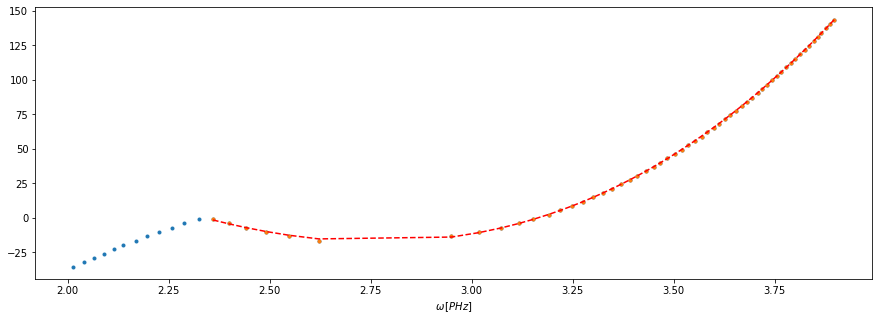

In [8]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

m.calculate(reference_point=2.355, order=3, scan=True, show_graph=True);

Itt láthatóvá válik pl., hogy a két oldalra milyen eredmény adódik (GD, GDD, TOD, FOD, QOD az adatok sorrendje) és hány adatot használtunk fel: 
> left side evaluated to [34.99186545 -737.69982878 -3030.40892732 0. 0.], used 13 points.

> right side evaluated to [-74.99734682 155.78155789 122.85346734  0.   0.], used 56 points.

     
Az interaktív felületet használva a kapott együtthatók jóval pontosabbak lettek. Ha már egyszer lefuttattuk a `build_phase` vagy a `calculate` metódusokat, akkor az objektum eltárolja az eredeti fázist. Ezt természetesen módosíthatjuk és számolhatjuk belőle a diszperziós együtthatókat ahogyan egy előző munkafüzetben már bemutattam. A következőképpen érhetjuk el a tárolt fázist:

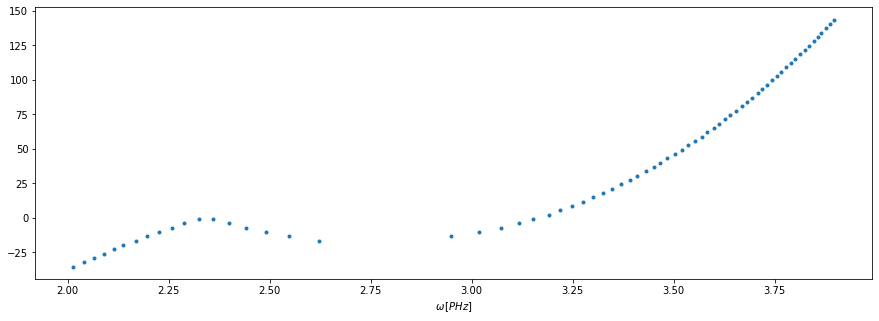

In [9]:
eredeti_fazis = m.phase

eredeti_fazis.plot()

In [10]:
eredeti_fazis.data

(array([2.32446267, 2.28753955, 2.25787113, 2.22564403, 2.19683193,
        2.16800742, 2.13767101, 2.1142057 , 2.0890698 , 2.06459245,
        2.04001903, 2.01404055, 2.35981505, 2.39827298, 2.44214592,
        2.49196519, 2.54733396, 2.62171747, 2.95002751, 3.01799527,
        3.07284106, 3.11615201, 3.15208013, 3.19068292, 3.21755217,
        3.24857127, 3.274549  , 3.3010034 , 3.32594962, 3.34740469,
        3.36913836, 3.39109505, 3.4093241 , 3.43187197, 3.45060647,
        3.46737518, 3.48430767, 3.50355548, 3.52090986, 3.53617851,
        3.5538584 , 3.56948242, 3.58292577, 3.59880699, 3.61254184,
        3.62631212, 3.64025813, 3.65431181, 3.66847443, 3.68267526,
        3.694666  , 3.70914376, 3.71888327, 3.73111135, 3.74342011,
        3.75573547, 3.76572153, 3.77826009, 3.79088242, 3.80105652,
        3.81383188, 3.8241297 , 3.83448328, 3.84748472, 3.85796532,
        3.86580382, 3.8763846 , 3.88702346, 3.89772088]),
 array([ -0.7864983 ,  -3.92809095,  -7.06968361, -10.2112

### 9.3 Szimuláció több SPP-vel
Bár a minimum-maximum módszer nem túl pontos magasabb rendű diszperzió esetén, a program képes tetszőleges számú SPP esetén is felépíteni a fázist. Erre mutatok itt egy példát.

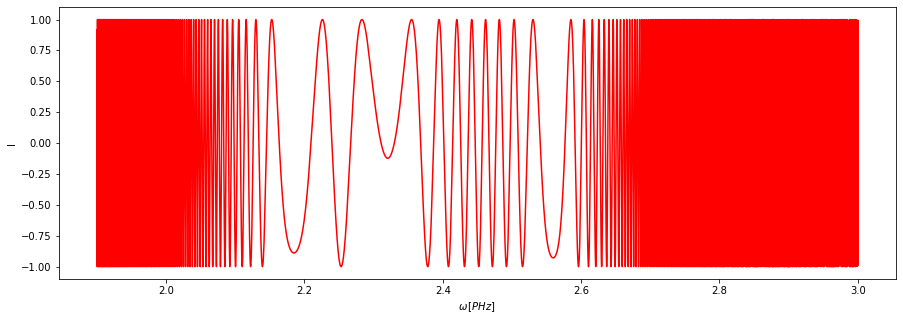

In [11]:
# visszaállítom a log szintet az alapbeállításra
logger.setLevel(logging.CRITICAL)

g = ps.Generator(1.9, 3, 2.355, delay=0, GD=100, GDD=3000, FOD=-500000, normalize=True, resolution=0.005)
g.generate()

myminmax = ps.MinMaxMethod(*g.data)
myminmax.plot()

Ezen az interferogramon 2.186, 2.322 és 2.561 PHz körfrekvenciaértéknél van állandó fázisú pont. Az alábbi cellában ismét az interaktív panelt használva bejelölöm a szélsőértékek helyét (az állandó fázisú pontokat is).

In [12]:
with ps.interactive():
    myminmax.init_edit_session(threshold=0.85)

1166 extremal points were recorded.


In [13]:
# az állandó fázisú pontok beállítása
myminmax.positions = 2.186, 2.322, 2.561

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

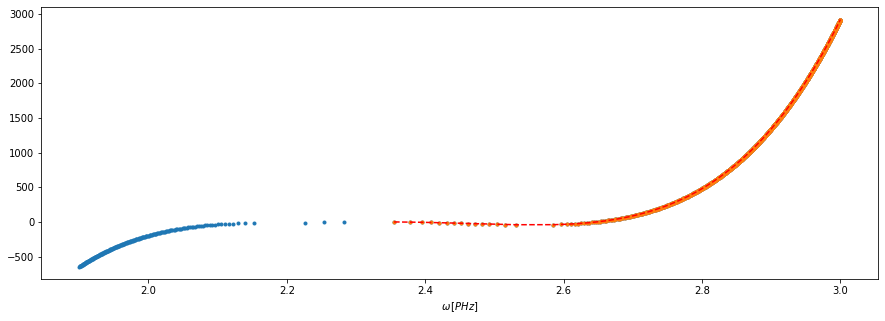

In [15]:
myminmax.calculate(2.355, 4, scan=True, show_graph=True);